In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,models,transforms
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
import numpy as np
import os
from torch.utils.data import DataLoader

In [2]:
data_transform={'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                             transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
               'val': transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])}

In [3]:
data_dir='hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transform[x]) for x in ['train','val']}

dataloader = {x : DataLoader(image_datasets[x],batch_size=4,shuffle=True) for x in ['train','val']}

dataset_size = {x: len(image_datasets[x]) for x in ['train','val']}

print(dataset_size['train'])
print(dataset_size['val'])
print(len(dataloader['train']))
print(len(dataloader['val']))

244
153
61
39


In [4]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: hymenoptera_data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: hymenoptera_data\val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [5]:
data_dir='hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transform[x]) for x in ['train','val']}

dataloader={x: DataLoader(image_datasets[x],batch_size=4,shuffle=True) for x in ['train','val']}

set_size =  {x: len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes

print(set_size['train'])
print(set_size['val'])
print(len(dataloader['train']))
print(len(dataloader['val']))

244
153
61
39


In [6]:
class_names = image_datasets['train'].classes

In [7]:
model = torchvision.models.resnet18(pretrained=True)

In [8]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [9]:
for param in model.parameters():
    param.requires_grad=False

In [10]:
in_ft=model.fc.in_features

In [11]:
for param in model.parameters():
    param.requires_grad=True

In [12]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [13]:
model.fc=nn.Linear(in_ft,2)

In [14]:
in_ft=model.fc.in_features

In [15]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [16]:
model.fc=nn.Linear(in_ft,2)

In [17]:
CUDA = torch.cuda.is_available()
if CUDA:
    cud=model.cuda()

In [18]:
correct=0
iterations=0

for inputs,labels in dataloader['train']:
    if iterations==1:
        break
        
    inputs=Variable(inputs)
    labels=Variable(labels)
    
    if CUDA:
        inputs = inputs.cuda()
        labels=labels.cuda()
        
    output=cud(inputs)
    _,predicted = torch.max(output.data,1)
    correct = correct + (predicted==labels).sum()
    
    print(inputs.shape)
    print(labels.shape)
    print(labels)
    print(output)
    print(output.shape)
    print(predicted)
    print(predicted.shape)
    print(correct)
    iterations = iterations +1

torch.Size([4, 3, 224, 224])
torch.Size([4])
tensor([1, 1, 0, 1], device='cuda:0')
tensor([[ 0.4331, -0.7801],
        [ 0.8204, -0.3020],
        [ 0.4260, -0.1875],
        [ 0.2111,  0.3479]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([4, 2])
tensor([0, 0, 0, 1], device='cuda:0')
torch.Size([4])
tensor(2, device='cuda:0')


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cud.fc.parameters(),lr=0.001,momentum=0.9)
schedule=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [20]:
scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [21]:
epochs=25

for i in range(epochs):
    scheduler.step()
    correct=0
    
    for images,labels in dataloader['train']:
        
        images=Variable(images)
        labels=Variable(labels)
        
        if CUDA:
            images = images.cuda()
            labels=labels.cuda()
            
        optimizer.zero_grad()
        output=cud(images)
        loss=criterion(output,labels)
        
        loss.backward()
        optimizer.step()
        
        
        _,predicted=torch.max(output.data,1)
        correct= correct + (predicted==labels).sum()
        
    accuracy=(100*correct/dataset_size['train'])
        
    print(f'Epoch: {i+1 :5}/{epochs} loss: {loss.item():3.3f} accuracy: {accuracy:5.5f}')

C:\Users\sidha\Anaconda3\envs\sid\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch:     1/25 loss: 0.259 accuracy: 65.00000
Epoch:     2/25 loss: 0.107 accuracy: 75.00000
Epoch:     3/25 loss: 0.159 accuracy: 79.00000
Epoch:     4/25 loss: 0.095 accuracy: 79.00000
Epoch:     5/25 loss: 0.620 accuracy: 81.00000
Epoch:     6/25 loss: 0.213 accuracy: 77.00000
Epoch:     7/25 loss: 0.940 accuracy: 83.00000
Epoch:     8/25 loss: 0.008 accuracy: 87.00000
Epoch:     9/25 loss: 0.668 accuracy: 79.00000
Epoch:    10/25 loss: 0.361 accuracy: 81.00000
Epoch:    11/25 loss: 0.045 accuracy: 84.00000
Epoch:    12/25 loss: 0.195 accuracy: 81.00000
Epoch:    13/25 loss: 0.859 accuracy: 82.00000
Epoch:    14/25 loss: 0.692 accuracy: 83.00000
Epoch:    15/25 loss: 0.028 accuracy: 84.00000
Epoch:    16/25 loss: 0.819 accuracy: 87.00000
Epoch:    17/25 loss: 0.301 accuracy: 86.00000
Epoch:    18/25 loss: 0.363 accuracy: 86.00000
Epoch:    19/25 loss: 0.888 accuracy: 83.00000
Epoch:    20/25 loss: 0.111 accuracy: 87.00000
Epoch:    21/25 loss: 0.084 accuracy: 86.00000
Epoch:    22/

In [30]:
cud.eval()
with torch.no_grad():
    correct=0
    total=0
    for images,labels in dataloader['val']:
        images=Variable(images)
        labels=Variable(labels)
        
        if CUDA:
            images=images.cuda()
            labels=labels.cuda()
            
        output=cud(images)
        _,predicted = torch.max(output.data,1)
        correct=correct + (predicted==labels).sum()
        total = total + labels.size(0)
    print(f'accuracy is {100*correct/total}%')

accuracy is 94%


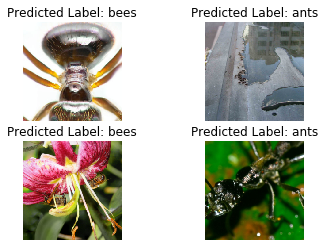

In [34]:
#Visualize some predictions 
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in dataloader['val']:
        if shown_batch == 1:
            break
        shown_batch += 1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = cud(images)                            #The output is of shape (4,2)
        _, preds = torch.max(outputs, 1)                        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            input_img = images.cpu().data[i]                    #Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)

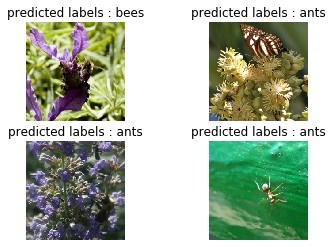

In [37]:
import matplotlib.pyplot as plt
plt.figure()
batch=0
index=0
with torch.no_grad():
    
    for images,labels in dataloader['val']:
        if batch==1:
            break
        batch = batch+1
        images=Variable(images)
        labels=Variable(labels)
        if CUDA:
            images=images.cuda()
            labels=labels.cuda()
            
        output=cud(images)
        _,pred=torch.max(output.data,1)
        
        
        
    for i in range(4):
        
        index= index+1
        ax=plt.subplot(2,2,index)
        ax.axis('off')
        ax.set_title(f'predicted labels : {class_names[pred[i]]}')
        img=images.cpu().data[i]
        img=img.numpy().transpose((1,2,0))
        mean=np.array([0.485,0.456,0.406])
        std=np.array([0.229,0.224,0.225])
        img=img*std+mean
        img=np.clip(img,0,1)
        plt.imshow(img)